# PP5 - Powdery Mildew Detection in Cherry Leaves

## Notebook 3 - Modelling and Evaluation

**Objectives**

* Awnser business requirement No. 2
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.
 
**Inputs**

Images from the following folders

```
.
└── input/
    ├── test/
    │   ├── healthy
    │   └── mildew
    ├── train/
    │   ├── healthy
    │   └── mildew
    └── validation/
        ├── healthy
        └── mildew
```

**Outputs**

* Analysis of Data Distribution across Sets (train, validation and test) and Labels (healthy and mildew)
    * Label distribution table, saved as: .png
    * Label distribution as a bar chart, saved as: .png
    * Set distribution as a pie chart, saved as: .png
* Image augmentation, each set is augmented and plotted
* Class indices to change prediction inference in labels, saved as pickle file: class_indices.pkl
* Machine learning model and model summary
* Model training
* Model saved as keras file: mildew_detector_model.keras
* Learning curve plot for model performance 
    * Loss, saved as: .png
    * Accuracy saved as: .png
* Model evaluation and saved as pickle file: evaluation.pkl
* Confusion matrix, saved as: .png
* Classification report, saved as: .png
* Prediction on random image files

---

## Preparation

### Manage Directories

**Change working directory**

In [1]:
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/ml-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspace/ml-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
working_dir = os.getcwd()
working_dir

'/workspace/ml-mildew-detection-in-cherry-leaves'

**Set Input Directory**

In [5]:
dataset_dir= 'input/cherry-leaves'
train_path = dataset_dir + '/train'
val_path = dataset_dir + '/validation'
test_path = dataset_dir + '/test'
print(f"Train Set Path: {train_path}")
print(f"Validation Set Path: {val_path}")
print(f"Test Set Path: {test_path}")

Train Set Path: input/cherry-leaves/train
Validation Set Path: input/cherry-leaves/validation
Test Set Path: input/cherry-leaves/test


**Set Output Directory**

In [6]:
version = 'v2'

In [7]:
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

print(file_path)

Old version is already available create a new version.
outputs/v2


**Set Label Names**

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'mildew']


**Load Image shape**

In [9]:
import joblib

In [10]:
image_shape = joblib.load(filename=f'outputs/{version}/avg_image_shape_train.pkl')
image_shape

(256, 256, 3)

---

## Analysis of Data Distribution across Sets and Labels

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


In [12]:
def display_data_distribution(dataset_dir, file_path):
    '''
    Display the distribution of data across different sets and labels

    Parameters:
        dataset_dir (str): The directory containing the datasets
        file_path (str): The directory where the output images will be saved

    Returns:
        None
    '''
    data = []
    for folder in ['test', 'train', 'validation']:
        folder_path = os.path.join(dataset_dir, folder)
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            frequency = len(os.listdir(label_path))
            data.append({'Set': folder, 'Label': label, 'Frequency': frequency})

    df_freq = pd.DataFrame(data)

    custom_palette = sns.color_palette("viridis", len(df_freq['Label'].unique()))

    # Display numerical data
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    table = plt.table(cellText=df_freq.values,
                      colLabels=df_freq.columns,
                      cellLoc='left',
                      loc='left')
    table.set_fontsize(10)
    for key, cell in table.get_celld().items():
        cell.set_linestyle('-')
        cell.set_edgecolor('lightgray')
    plt.savefig(os.path.join(file_path, 'labels_distribution_table.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the bar plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_palette)
    plt.title('Distribution of Labels in Different Sets', fontsize=16, fontweight='bold')
    plt.xlabel('Set', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.savefig(os.path.join(file_path, 'labels_distribution_bar.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(df_freq.groupby('Label')['Frequency'].sum(), labels=None,
            autopct='%1.1f%%', startangle=140, colors=custom_palette)
    plt.title('Total Data in Each Label', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.legend(df_freq['Label'].unique(), fontsize=12, loc='lower right')
    plt.savefig(os.path.join(file_path, 'labels_pie_chart.png'), bbox_inches='tight', dpi=150)
    plt.show()

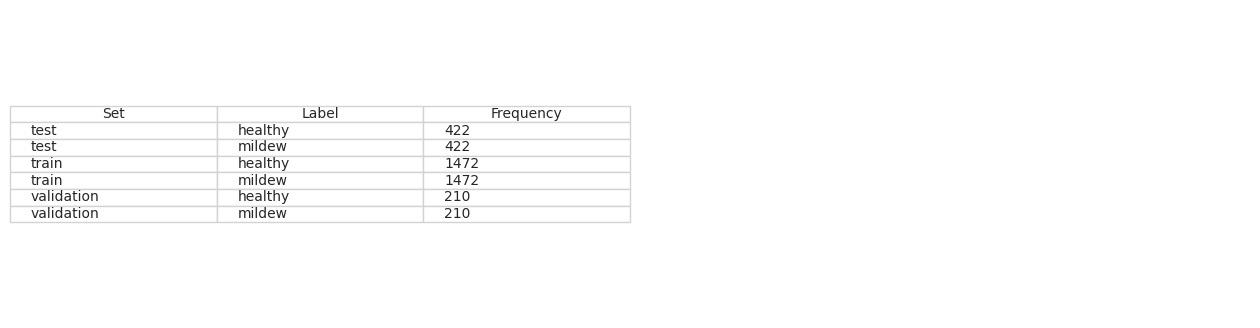

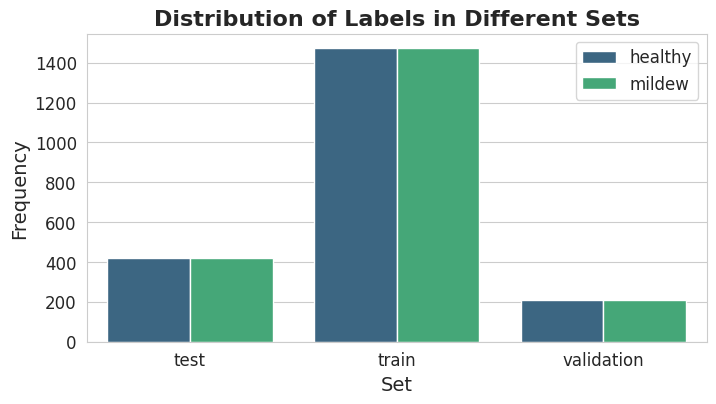

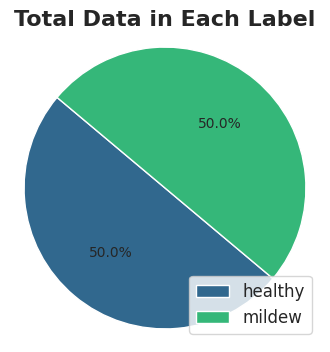

In [13]:
display_data_distribution(dataset_dir, file_path)

---

## Image Augmentation

### Setup Augmentation

**Import Libraries**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-24 16:49:03.981954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Augmentation Pipeline**

In [15]:
augmentation_data = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    rotation_range=0.2,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    rescale=1.0/255.0,
)

**Batch Size**

In [16]:
batch_size = 16

**Augmentation Train image Set**

In [17]:
train_set = augmentation_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Validation image Set**

In [18]:
validation_set = augmentation_data.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Test image Set**

In [19]:
test_set = augmentation_data.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

### Plot Augmented Images

In [20]:
label_names = {i: label for i, label in enumerate(labels)}
print('Label names:', label_names)


Label names: {0: 'healthy', 1: 'mildew'}


**Augmented Train Image Set**

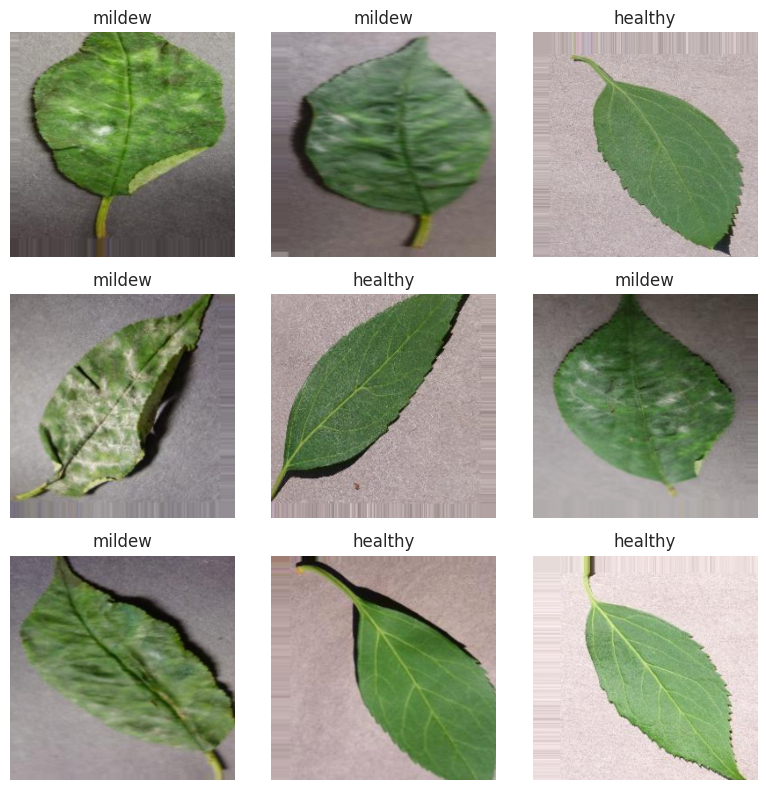

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(train_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Validation Image Set**

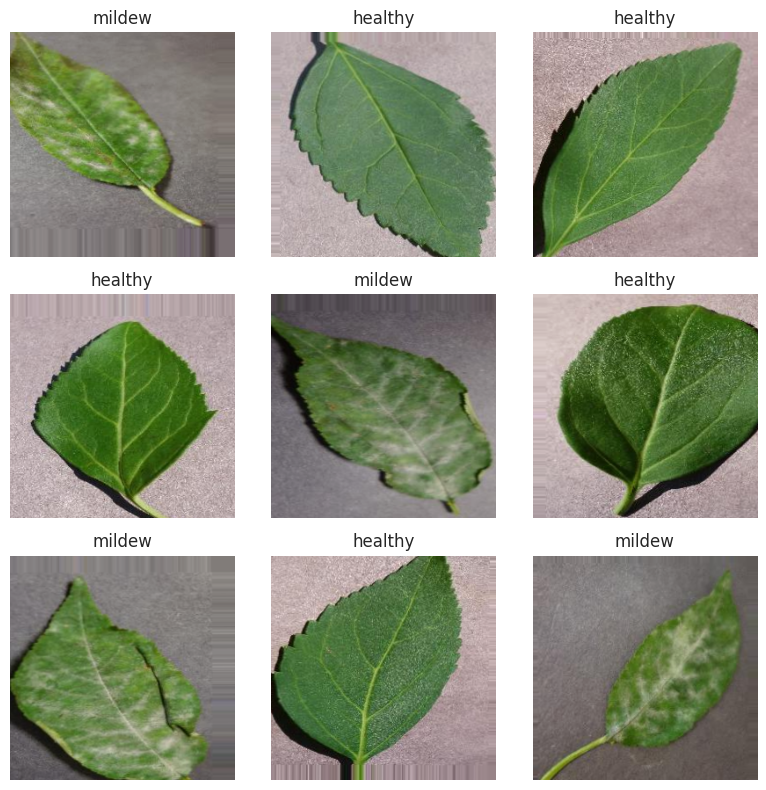

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(validation_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Test Image Set**

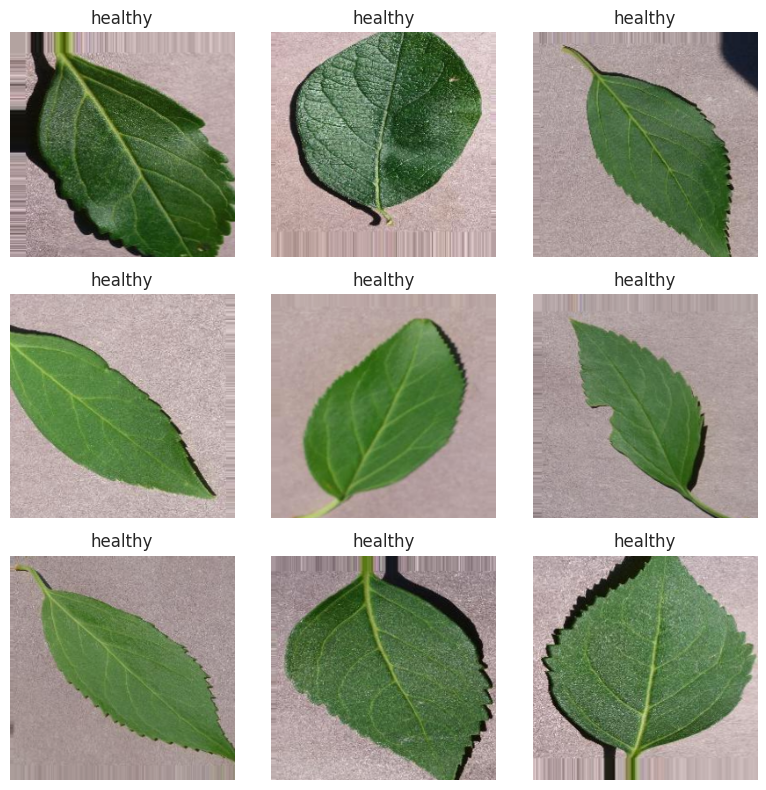

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(test_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Save class_indicies**

In [24]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

---

## Building the Model

**Import Model Packages**

In [25]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam

### Model

In [26]:
def build_model():
    """
    Description:
        Builds a convolutional neural network (CNN) model

    Parameters:
        image_shape - tuple: The shape of input images (height, width, channels)

    Returns:
        model - Sequential: A TensorFlow Keras Sequential model
    """

    model = Sequential()

    # Input Layer
    model.add(Conv2D(filters=16,
                     kernel_size=(3, 3),
                     input_shape=image_shape,
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layers
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [27]:
model = build_model()

/workspace/.pip-modules/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,710,113 (14.15 MB)

 Trainable params: 3,710,113 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

**Early Stopping**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

### Model Training

**Model Fit**

In [31]:
model.fit(train_set,
          batch_size=batch_size,
          epochs=20,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/20


/workspace/.pip-modules/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 270ms/step - accuracy: 0.7560 - loss: 0.5006 - val_accuracy: 0.9238 - val_loss: 0.1718
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.9748 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 264ms/step - accuracy: 0.9858 - loss: 0.0475 - val_accuracy: 0.9952 - val_loss: 0.0113
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.9977 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.9902 - loss: 0.0307 - val_accuracy: 0.9976 - val_loss: 0.0080
Epoch 5: early stopping


**Save Model**

In [32]:
model.save(f'outputs/{version}/mildew_detector_model.keras')

---

## Model Performance

**Model Learning Curve**

In [33]:
losses = pd.DataFrame(model.history.history)

**Loss**

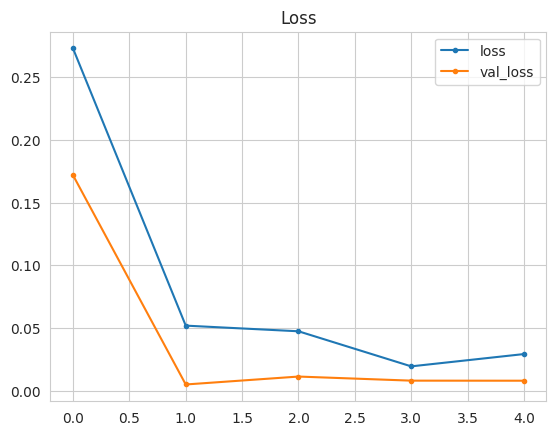

In [34]:
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_loss_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Accuracy**

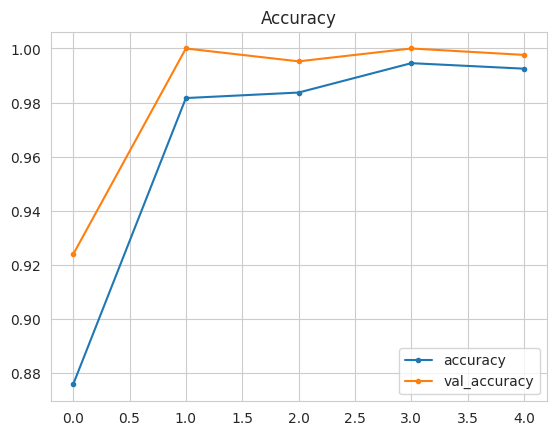

In [35]:
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_accuracy_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Loss and Accuracy**

---

## Model Evaluation

**Load Model**

In [75]:
from tensorflow.keras.models import load_model

In [76]:
try:
    loaded_model = load_model(f'outputs/{version}/mildew_detector_model.keras')
    print(f"Model {version} loaded successfully!")
except Exception as e:
    print("Error loading model:", e)

Model v2 loaded successfully!


In [77]:
evaluation = model.evaluate(test_set)

print("Evaluation Results:")
print(f"Accuracy: {evaluation[1] * 100:.2f}%")
print(f"Loss: {evaluation[0]:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.9996 - loss: 0.0019
Evaluation Results:
Accuracy: 99.76%
Loss: 0.0054


In [78]:
joblib.dump(value=evaluation,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v2/evaluation.pkl']

**Confusion Matrix**

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [80]:
labels

['healthy', 'mildew']

53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step


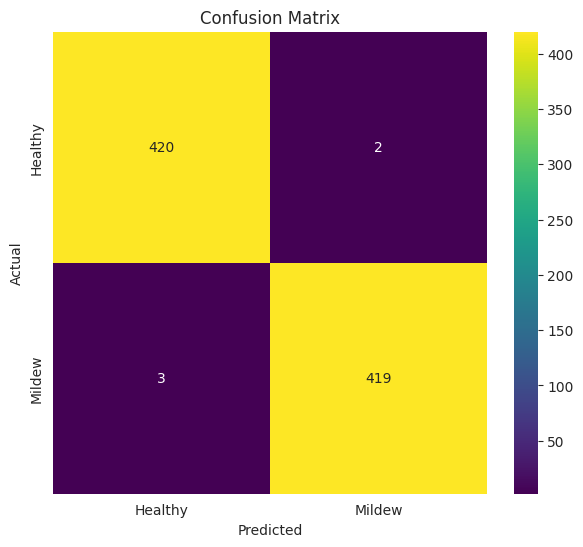

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pred = model.predict(test_set)
y_pred = np.concatenate(np.round(pred).astype(int))
target_names = labels

cm = confusion_matrix(test_set.classes, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='viridis',
            xticklabels=['Healthy', 'Mildew'],
            yticklabels=['Healthy', 'Mildew'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)

plt.show()



**Classification Report**

              precision    recall  f1-score   support

     healthy       0.99      1.00      0.99       422
      mildew       1.00      0.99      0.99       422

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



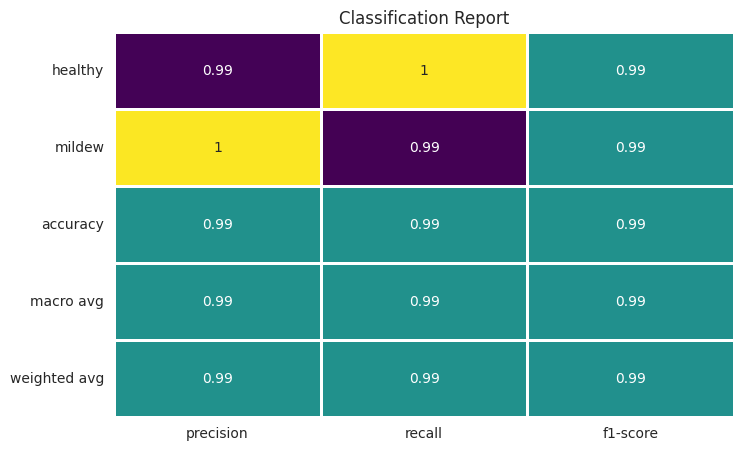

In [92]:
print(classification_report(test_set.classes, y_pred, target_names=target_names))

clf = classification_report(test_set.classes, y_pred, target_names=target_names, output_dict=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pd.DataFrame(clf).iloc[:-1, :].T, annot=True, cmap="viridis", cbar=False, linewidths=1)
plt.title('Classification Report')

plt.savefig(f'{file_path}/classification_report.png', bbox_inches='tight', dpi=150)

plt.show()

---

## Predict on new data

In [93]:
import numpy as np

Image shape: (256, 256), Image mode: RGB


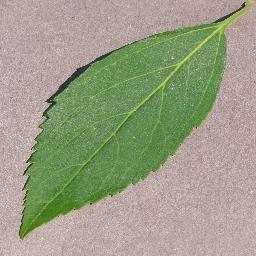

In [109]:
from tensorflow.keras.preprocessing import image
import os

pointer = 30
label = labels[0]

image_path = os.path.join(
    test_path, label, os.listdir(os.path.join(test_path, label))[pointer])

pil_image = image.load_img(image_path,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [110]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [111]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
healthy 100.0%
